In [33]:
plt.style.use('dark_background')
import numpy as np
import scipy.stats as si
import matplotlib.pyplot as plt
import math
from scipy.stats import norm
import pandas as pd



For a trinomial tree, the formula for the stock price is given by
\begin{align*}
S^n_k=S_0 u^{n
}d^k,\qquad n=0,1,...,N\quad k=0,1,...,n
\end{align*}
is the $k^{th}$ possible stock price level at time $n$, and $V^n_k$ is the time-$n$ option value when the stock price is $S^n_k$. 





\begin{align*}{Euro. option: }V^{n}_k&=e^{-r\triangle t}[quV^{n+1}_{k} + qmV^{n+1}_{k+1}+qdV^{n+1}_{k+2}]\quad\text{for each }k=0,1,...,n \\
\end{align*}
\begin{align*}{Amer. option: }V^{n}_k&=max(g(S^n_k),e^{-r\triangle t}[quV^{n+1}_{k} + qmV^{n+1}_{k+1}+qdV^{n+1}_{k+2}])\quad\text{for each }k=0,1,...,n \\
\end{align*}

In case one wants to visualize the tree

*Choosing the tree parameters*

There are a number of ways we can choose the tree parameters. Here we use the Kamrad_Ritchken model:
	\begin{align*}
	\quad u=e^{\lambda\sigma\sqrt{\triangle t}},\quad m=1,\quad d=e^{-\lambda\sigma \sqrt{\triangle t}}\\
    \quad qu=\frac{1}{2\lambda^2}+\frac{(r-\frac{\sigma^2}{2})\sqrt{\triangle t}}{2\sigma\lambda},\quad qm=1-\frac{1}{\lambda^2},\quad qd=\frac{1}{2\lambda^2}-\frac{(r-\frac{\sigma^2}{2})\sqrt{\triangle t}}{2\sigma\lambda}
    \end{align*}

In [2]:
def GetKamrad_RitchkenPara(lambda_param,r, T, N, sigma):
    dt = T/N
    u = np.exp(sigma*lambda_param * np.sqrt(dt))
    m = 1
    d= 1/u
    R = np.exp(r * dt)
    qu = ((1) / (2*lambda_param**2)) + (r-0.5*sigma**2)*np.sqrt(dt)/(2*sigma*lambda_param)
    qm = 1 - (1/(lambda_param**2))
    qd = ((1) / (2*lambda_param**2)) - (r-0.5*sigma**2)*np.sqrt(dt)/(2*sigma*lambda_param)
    return u, d, qu, qm, qd, R


In [3]:
tree_param = GetKamrad_RitchkenPara

In [4]:
#Defining payoffs
CallPayoff = lambda x : np.maximum(x - K, 0)
PutPayoff = lambda x : np.maximum(K - x, 0) # The payoff function to be used: g(s)=max(K-s, 0)

In [5]:
def Populate_Tree_Tri(S0, T, r, N,sigma):
        
    # Create empty arrays to store the stock price at each node
    S = np.zeros((2*N+1, N+1))
    S[0,0]=S0
    u, d, qu, qm, qd, R = GetKamrad_RitchkenPara(lambda_param,r, T, N, sigma)
    
    # Set up S[k,n] = s0 * u^(n) * d^k
    for t in range(N+1):
        S[0:2*t+1, t] = S0 * u**np.arange(t, -t-1, -1).astype(float)
        
    return S     # get the function to return the whole tree of stock prices

In [6]:
S0, r, T, sigma, K = 100, 0.01, 1, 0.2, 100     # Option and market parameters
N = 2                                          # Number of periods
lambda_param = 1

In [7]:
#Visualize Tree
Populate_Tree_Tri(S0, T, r, N,sigma)

array([[100.        , 115.19099102, 132.68964411],
       [  0.        , 100.        , 115.19099102],
       [  0.        ,  86.81234454, 100.        ],
       [  0.        ,   0.        ,  86.81234454],
       [  0.        ,   0.        ,  75.36383164]])

In [8]:
def Option_Price_TrinomialTree(S0, T, r, N,payoff,sigma,tree_param,american=False):
        
    # Create empty arrays to store the stock price and option value at each node
    V = np.zeros((2*N+1, N+1))
    S = Populate_Tree_Tri(S0, T, r, N,sigma)
    
    #Get tree parameters
    u, d, qu, qm, qd, R = tree_param(lambda_param,r, T, N, sigma)
    
    # Compute the option price at terminal time
    V[:,N] = payoff(S[:,N])
    
    # Loop backward in time
    for t in reversed(range(N)):
        if american:
            V[0:2*t+1, t] = np.maximum(payoff(S[0:2*t+1, t]), (qu*V[0:2*t+1,t+1] + qm*V[1:2*t+2,t+1] + qd*V[2:2*t+3,t+1])/R)
            # The R is going to be taken as R=exp(r dt), which represents the interest rate factor
        else:
            V[0:2*t+1, t] = (qu*V[0:2*t+1,t+1] + qm*V[1:2*t+2,t+1] + qd*V[2:2*t+3,t+1])/R
        
    return V[0][0]      # get the function to return the whole tree of stock prices and option values

In [9]:
def BlackScholesCallPrice(S, K, T, sigma, r,Call=True):
    """European Call option price in the Black-Scholes model
    S: initial value for the stock price
    K: strike
    T: maturity
    r: constant risk-free rate
    """
    d1 = (np.log(S/K) + (r+.5*sigma**2)*T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if Call:
        return S*norm.cdf(d1) - K*np.exp (-r*T) * norm.cdf (d2)
    else:
        return -S*norm.cdf(-d1) + K*np.exp (-r*T) * norm.cdf (-d2)

Now we try to use a 2-period tree to price a European put option which payoff function is $(K-S_T)^{+}$. Parameters are: initial stock price $S_0=100$, strike price $K=100$, maturity $T=1$ year, interest rate $r=1\%$ and volatility $\sigma=20\%$.

For simplicity, this time we'll write the Kamrad_Ritchken parameters inside the trinomial function as it makes it easier to manipulate

In [10]:
lambda_param = 1
tree_param=GetKamrad_RitchkenPara
S0, r, T, sigma, K = 100, 0.01, 1, 0.2, 100     # Option and market parameters
N = 2 # Number of periods

#European Case
print("European Put Option Price using Trinomial Tree", 
      Option_Price_TrinomialTree(S0, T, r, N,PutPayoff,sigma,tree_param, american=False))

#American Case
print("American Put Option Price using Trinomial Tree",
      Option_Price_TrinomialTree(S0, T, r, N,PutPayoff,sigma,tree_param, american=True))

European Put Option Price using Trinomial Tree 6.536557439760035
American Put Option Price using Trinomial Tree 6.792905166530113


### Plot of Trinomial price for varying N for a Call with the same parameters as before

In [11]:
S0, r, T, sigma, K = 100, 0.01, 1, 0.2, 100
lambda_param=1
N=2
Option_Price_TrinomialTree(S0, T, r, N,CallPayoff,sigma,tree_param, american=False)

7.529081291747985

In [12]:
S0, r, T, sigma, K = 100, 0.01, 1, 0.2, 100
lambda_param=1
N=2
Option_Price_TrinomialTree(S0, T, r, N,CallPayoff,sigma,tree_param, american=False)

7.529081291747985

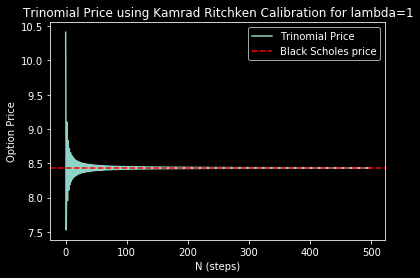

In [34]:
lambda_param=1
prices_lambda_100 = [Option_Price_TrinomialTree(S0, T, r, i,
                    CallPayoff,sigma,tree_param, american=False) for i in range(1,500)]
plt.plot(prices_lambda_100,label="Trinomial Price")
plt.axhline(y=BlackScholesCallPrice(S0, K, T, sigma, r,Call=True), 
            color='r', linestyle='dashed',label="Black Scholes price")
plt.title("Trinomial Price using Kamrad Ritchken Calibration for lambda=1")
plt.legend(loc="best")
plt.xlabel("N (steps)")
plt.ylabel("Option Price")
plt.show()

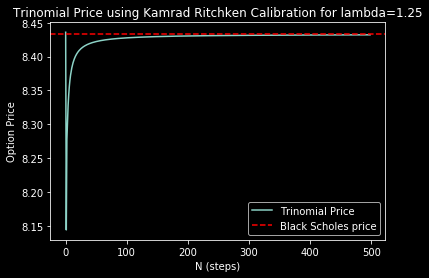

In [35]:
lambda_param=1.25
prices_lambda_125 = [Option_Price_TrinomialTree(S0, T, r, i,
                    CallPayoff,sigma,tree_param, american=False) for i in range(1,500)]
plt.plot(prices_lambda_125,label="Trinomial Price")
plt.axhline(y=BlackScholesCallPrice(S0, K, T, sigma, r,Call=True), 
            color='r', linestyle='dashed',label="Black Scholes price")
plt.legend(loc="best")
plt.title("Trinomial Price using Kamrad Ritchken Calibration for lambda=1.25")
plt.xlabel("N (steps)")
plt.ylabel("Option Price")
plt.show()

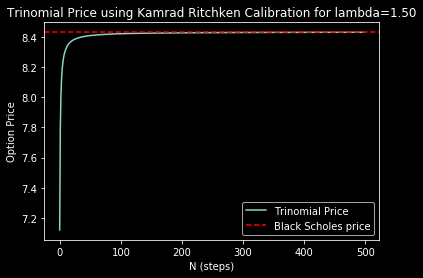

In [36]:
lambda_param=1.5
prices_lambda_150 = [Option_Price_TrinomialTree(S0, T, r, i,
                    CallPayoff,sigma,tree_param, american=False) for i in range(1,500)]
plt.plot(prices_lambda_150,label="Trinomial Price")
plt.axhline(y=BlackScholesCallPrice(S0, K, T, sigma, r,Call=True), color='r', 
            linestyle='dashed',label="Black Scholes price")
plt.legend(loc="best")
plt.title("Trinomial Price using Kamrad Ritchken Calibration for lambda=1.50")
plt.xlabel("N (steps)")
plt.ylabel("Option Price")
plt.show()

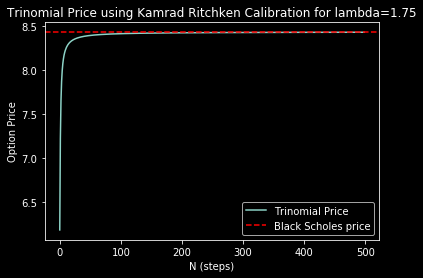

In [37]:
lambda_param=1.75
prices_lambda_175 = [Option_Price_TrinomialTree(S0, T, r, i,
                    CallPayoff,sigma,tree_param, american=False) for i in range(1,500)]
plt.plot(prices_lambda_175,label="Trinomial Price")
plt.axhline(y=BlackScholesCallPrice(S0, K, T, sigma, r,Call=True), color='r', linestyle='dashed',label="Black Scholes price")
plt.legend(loc="best")
plt.title("Trinomial Price using Kamrad Ritchken Calibration for lambda=1.75")
plt.xlabel("N (steps)")
plt.ylabel("Option Price")
plt.show()

### Let's work now with different values of S and see how it impacts the option price

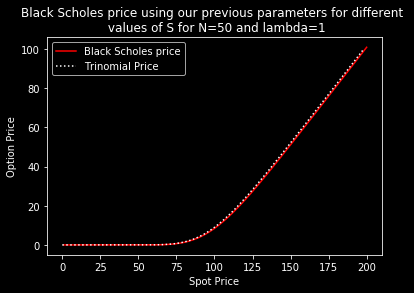

In [38]:
x = np.linspace(1,200,200)
plt.plot(x,BlackScholesCallPrice(x, K, T, sigma, r,Call=True),label="Black Scholes price", color="r")
#plt.axhline(y=BlackScholesCallPrice(S0, K, T, sigma, r,Call=True), color='r', linestyle='solid',
            #label="Black Scholes price with S=100")
lambda_param=1
N=500
prices_different_S0 = [Option_Price_TrinomialTree(i, T, r, N,
                    CallPayoff,sigma,tree_param, american=False) for i in range(1,200)]
plt.plot(prices_different_S0,label="Trinomial Price",color='w',linestyle='dotted')

plt.title("Black Scholes price using our previous parameters for different \n values of S for N=50 and lambda=1")
plt.xlabel("Spot Price")
plt.ylabel("Option Price")
plt.legend(loc="best")


## Part 3

Fixing now N=500, let's produce a table showing the differences between the trinomial tree prices and the exact Black-Scholes prices for a European call option under several different values of initial stock price S0 (e.g. in the
range of [70, 130]) as well as different values of λ ∈ {1, 1.25, 1.5, 1.75}.

In [18]:
#lambda=1
lambda_param=1
N=500
prices_Tri_S0_70_130 = [Option_Price_TrinomialTree(i, T, r, N,
                        CallPayoff,sigma,tree_param, american=False) for i in range(70,131,10)]
prices_BS_S0_70_130 = [BlackScholesCallPrice(x, K, T, sigma, r,Call=True) for x in range(70,131,10)]
Stock_range=[i for i in range(70,131,10)]

Table_lambda_100 = pd.DataFrame({'Price Trinomial':prices_Tri_S0_70_130,"Price Black Scholes":
                                prices_BS_S0_70_130,
                                "Stock Prices":Stock_range}).set_index("Stock Prices")
Table_lambda_100["Difference in %"]=(Table_lambda_100["Price Trinomial"]/Table_lambda_100["Price Black Scholes"] - 1)*100

Table_lambda_100

,Price Trinomial,Price Black Scholes,Difference in %
Stock Prices,,,
70,0.278311,0.279521,-0.433121
80,1.303312,1.302245,0.081942
90,3.860321,3.861404,-0.028057
100,8.429346,8.433319,-0.047104
110,14.947178,14.944704,0.016557
120,22.941777,22.941877,-0.000434
130,31.896781,31.896319,0.001449


In [19]:
#lambda=1.25
lambda_param=1.25
N=500
prices_Tri_S0_70_130 = [Option_Price_TrinomialTree(i, T, r, N,
                        CallPayoff,sigma,tree_param, american=False) for i in range(70,131,10)]
prices_BS_S0_70_130 = [BlackScholesCallPrice(x, K, T, sigma, r,Call=True) for x in range(70,131,10)]
Stock_range=[i for i in range(70,131,10)]

Table_lambda_125 = pd.DataFrame({'Price Trinomial':prices_Tri_S0_70_130,"Price Black Scholes":
                                 prices_BS_S0_70_130,
                               "Stock Prices":Stock_range}).set_index("Stock Prices")

Table_lambda_125["Difference in %"]=(Table_lambda_125["Price Trinomial"]
                                     /Table_lambda_125["Price Black Scholes"] - 1)*100

Table_lambda_125

,Price Trinomial,Price Black Scholes,Difference in %
Stock Prices,,,
70,0.278926,0.279521,-0.212943
80,1.301272,1.302245,-0.074759
90,3.862726,3.861404,0.034231
100,8.432182,8.433319,-0.013475
110,14.946319,14.944704,0.010804
120,22.942402,22.941877,0.002291
130,31.896500,31.896319,0.000569


In [20]:
#lambda=1.5
lambda_param=1.5
N=50
prices_Tri_S0_70_130 = [Option_Price_TrinomialTree(i, T, r, N,
                        CallPayoff,sigma,tree_param, american=False) for i in range(70,131,10)]
prices_BS_S0_70_130 = [BlackScholesCallPrice(x, K, T, sigma, r,Call=True) for x in range(70,131,10)]
Stock_range=[i for i in range(70,131,10)]

Table_lambda_150 = pd.DataFrame({'Price Trinomial':prices_Tri_S0_70_130,
                                 "Price Black Scholes":prices_BS_S0_70_130,
                               "Stock Prices":Stock_range}).set_index("Stock Prices")

Table_lambda_150["Difference in %"]=(Table_lambda_150["Price Trinomial"]
                                     /Table_lambda_150["Price Black Scholes"] - 1)*100

Table_lambda_150

,Price Trinomial,Price Black Scholes,Difference in %
Stock Prices,,,
70,0.279585,0.279521,0.022770
80,1.302914,1.302245,0.051379
90,3.876481,3.861404,0.390462
100,8.408380,8.433319,-0.295712
110,14.950654,14.944704,0.039814
120,22.947005,22.941877,0.022356
130,31.892741,31.896319,-0.011218


In [21]:
#lambda=1.75
lambda_param=1.75
N=500
prices_Tri_S0_70_130 = [Option_Price_TrinomialTree(i, T, r, N,
                        CallPayoff,sigma,tree_param, american=False) 
                        for i in range(70,131,10)]
prices_BS_S0_70_130 = [BlackScholesCallPrice(x, K, T, sigma, r,Call=True) for x in range(70,131,10)]
Stock_range=[i for i in range(70,131,10)]

Table_lambda_175 = pd.DataFrame({'Price Trinomial':prices_Tri_S0_70_130,"Price Black Scholes":prices_BS_S0_70_130,
                               "Stock Prices":Stock_range}).set_index("Stock Prices")
Table_lambda_175["Difference in %"]=(Table_lambda_175["Price Trinomial"]/Table_lambda_175["Price Black Scholes"] - 1)*100

Table_lambda_175

,Price Trinomial,Price Black Scholes,Difference in %
Stock Prices,,,
70,0.279559,0.279521,0.013621
80,1.302503,1.302245,0.019767
90,3.861996,3.861404,0.015321
100,8.429223,8.433319,-0.048563
110,14.942738,14.944704,-0.013156
120,22.942899,22.941877,0.004455
130,31.896507,31.896319,0.000591


In [22]:
print(Table_lambda_100["Difference in %"].mean())
print(Table_lambda_125["Difference in %"].mean())
print(Table_lambda_150["Difference in %"].mean())
print(Table_lambda_175["Difference in %"].mean())

-0.058395398637659364
-0.036183249999908816
0.03140738154283618
-0.0011376106541053207


Which gives us the optimal lambda to use which is the smallest difference in absolute value

## American options

In [23]:
N=50
lambda_param=1.5
K=100
#Example: EU VS US

print("EU Call Option Price", Option_Price_TrinomialTree(120, T, r, N,
       CallPayoff,sigma,tree_param, american=False))
print("US Call Option Price", Option_Price_TrinomialTree(120, T, r, N,
       CallPayoff,sigma,tree_param, american=True))

EU Call Option Price 22.947005479556704
US Call Option Price 22.947005479556704


## Plotting American option price vs Instrinsic Value

Text(0, 0.5, 'Option Price')

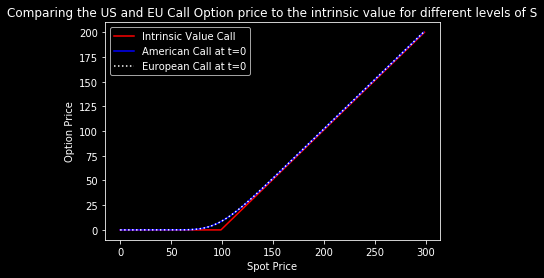

In [39]:
lambda_param=1.5
N=500
prices_lambda_150_Am_Call = [Option_Price_TrinomialTree(i, T, r, N,
                       CallPayoff,sigma,tree_param, american=False) for i in range(1,300)]
prices_lambda_150_Eu_Call = [Option_Price_TrinomialTree(i, T, r, N,
                       CallPayoff,sigma,tree_param, american=True) for i in range(1,300)]
x = np.linspace(1,300,300)
plt.plot(CallPayoff(x),label='Intrinsic Value Call',color="r")
plt.plot(prices_lambda_150_Am_Call,label='American Call at t=0',color="b")
plt.plot(prices_lambda_150_Eu_Call,label='European Call at t=0',color="w",linestyle='dotted')
plt.legend(loc="best")
plt.title("Comparing the US and EU Call Option price to the intrinsic value for different levels of S")
plt.xlabel("Spot Price")
plt.ylabel("Option Price")



Text(0, 0.5, 'Option Price')

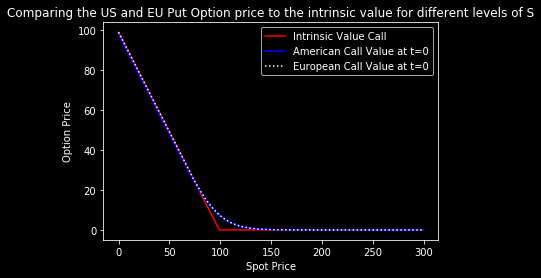

In [40]:
lambda_param=1.5
N=500
prices_lambda_150_Am_Put = [Option_Price_TrinomialTree(i, T, r, N,
                       PutPayoff,sigma,tree_param, american=False) for i in range(1,300)]
prices_lambda_150_Eu_Put = [Option_Price_TrinomialTree(i, T, r, N,
                       PutPayoff,sigma,tree_param, american=True) for i in range(1,300)]
x = np.linspace(1,300,300)
plt.plot(PutPayoff(x),label='Intrinsic Value Call',color="r")
plt.plot(prices_lambda_150_Am_Put,label='American Call Value at t=0',color="b")
plt.plot(prices_lambda_150_Eu_Put,label='European Call Value at t=0',color="w",linestyle='dotted')
plt.legend(loc="best")
plt.title("Comparing the US and EU Put Option price to the intrinsic value for different levels of S")
plt.xlabel("Spot Price")
plt.ylabel("Option Price")

#### Now American/European - Intrinsic

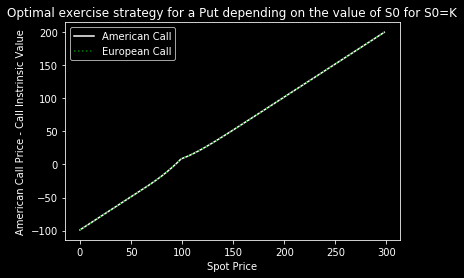

In [53]:
N=500
American_early_exercise = [Option_Price_TrinomialTree(i, T, r, N,
        CallPayoff,sigma,tree_param, american=True) - PutPayoff(i) for i in range(1,300)]
European_early_exercise = [Option_Price_TrinomialTree(i, T, r, N,
        CallPayoff,sigma,tree_param, american=False) - PutPayoff(i) for i in range(1,300)]
plt.plot(American_early_exercise, label="American Call", color="w")
plt.plot(European_early_exercise, label="European Call", color="g",linestyle='dotted')
plt.title("Optimal exercise strategy for a Put depending on the value of S0 for S0=K")
plt.xlabel("Spot Price")
plt.ylabel("American Call Price - Call Instrinsic Value")
plt.legend(loc="best")

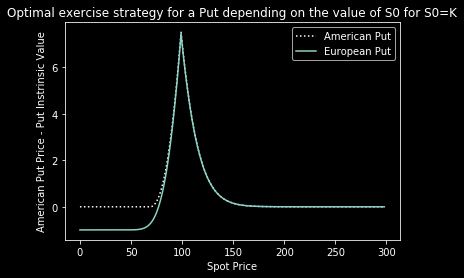

In [41]:
N=500
American_early_exercise = [Option_Price_TrinomialTree(i, T, r, N,
        PutPayoff,sigma,tree_param, american=True) - PutPayoff(i) for i in range(1,300)]
European_early_exercise = [Option_Price_TrinomialTree(i, T, r, N,
        PutPayoff,sigma,tree_param, american=False) - PutPayoff(i) for i in range(1,300)]
plt.plot(American_early_exercise, label="American Put",color="w",linestyle='dotted')
plt.plot(European_early_exercise, label="European Put")
plt.title("Optimal exercise strategy for a Put depending on the value of S0 for S0=K")
plt.xlabel("Spot Price")
plt.ylabel("American Put Price - Put Instrinsic Value")
plt.legend(loc="best")

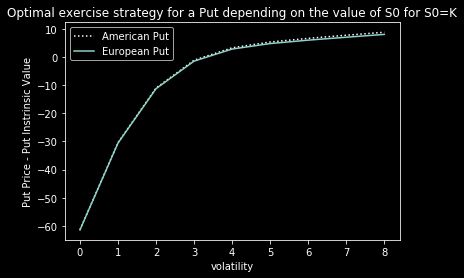

In [52]:
N=500
American_early_exercise = [Option_Price_TrinomialTree(100, T, r, N,
        PutPayoff,i,tree_param, american=True) - PutPayoff(i) for i in range(1,10)]
European_early_exercise = [Option_Price_TrinomialTree(100, T, r, N,
        PutPayoff,i,tree_param, american=False) - PutPayoff(i) for i in range(1,10)]
plt.plot(American_early_exercise, label="American Put",color="w",linestyle='dotted')
plt.plot(European_early_exercise, label="European Put")
plt.title("Optimal exercise strategy for a Put depending on the value of S0 for S0=K")
plt.xlabel("volatility")
plt.ylabel("Put Price - Put Instrinsic Value")
plt.legend(loc="best")

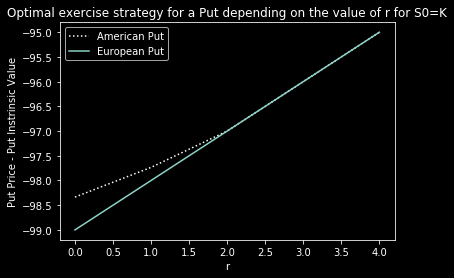

In [51]:
N=500
American_early_exercise = [Option_Price_TrinomialTree(100, T, i, N,
        PutPayoff,sigma,tree_param, american=True) - PutPayoff(i) for i in range(1,6)]
European_early_exercise = [Option_Price_TrinomialTree(100, T, i, N,
        PutPayoff,sigma,tree_param, american=False) - PutPayoff(i) for i in range(1,6)]
plt.plot(American_early_exercise, label="American Put",color="w",linestyle='dotted')
plt.plot(European_early_exercise, label="European Put")
plt.title("Optimal exercise strategy for a Put depending on the value of r for S0=K")
plt.xlabel("r")
plt.ylabel("Put Price - Put Instrinsic Value")
plt.legend(loc="best")